# Clustering in PySpark's MLlib Project

**Project Title:** University Clustering for the Greater Good

**Objective**

You are a data scientist employed by the ABCDE Foundation, a non-profit organization whose mission is to increase college graduation rates for underprivileged populations. Through advocacy and targeted outreach programs, ABCDE strives to identify and alleviate barriers to educational achievement. ABCDE is driven by the belief that with the right supports, an increase in college attendance and completion rates can be achieved, thereby weakening the grip of the cycles of poverty and social immobility affecting many of our communities.

ABCDE is committed to developing a more data driven approach to decision making. As a prelude to future analyses, ABCDE has requested that you analyze the data to identify clusters of similar colleges and universities.

**Your Task**

Use cluster analysis to identify the groups of characteristically similar schools in the CollegeScorecard.csv dataset. A few questions are outlined below to help guide you. 

## Considerations:

 - Data Preparation 
 - How will you deal with missing values? 
 - Are there any categorical variables in the dataset? How will you deal with those? 
 - Consider experimenting with hyperparameter optimization techniques

These are the (sometimes subjective) questions you need to figure out as a data scientist. It's highly recommended that you familiarize yourself with the dataset's dictionary and documentation (see "Data Dictionary description below), as well as the theory and technical characteristics of the algorithm(s) you're using.

**Interpretation**

Is it possible to explain what each cluster represents? Did you retain or prepare a set of features that enables a meaningful interpretation of the clusters? Do the compositions of the clusters seem to make sense?

**Validation**

How will you measure the validity of your clustering process? Which metrics will you use and how will you apply them?

*Important Note:*

This is an open-ended assignment (as many or most real-life data science projects are). Your only constraints are that you must use the data provided, execute high-quality and justifiable clustering technique, provide your rationale for the decisions you made, and ultimately produce meaningful cluster labels. Three questions have been provided below to help get you started and provide some direction for your analysis, but feel free to explore the dataset in your own unique way and share it with the class! The sky is the limit!

**Source:** https://data.world/exercises/cluster-analysis-exercise-2

**Data:** CollegeScorecard.csv <br>
**Data Dictionary:** CollegeScoreCardDataDictionary-09-12-2015.csv

In [1]:
# First let's create our PySpark instance
# import findspark
# findspark.init()

import pyspark  # only run after findspark.init()
from pyspark.sql import SparkSession

# May take awhile locally
spark = SparkSession.builder.appName("Clustering_Project").getOrCreate()

cores = spark._jsc.sc().getExecutorMemoryStatus().keySet().size()
print("You are working with", cores, "core(s)")
spark

22/10/13 13:15:36 WARN Utils: Your hostname, masoud-ubuntu resolves to a loopback address: 127.0.1.1; using 192.168.7.139 instead (on interface wlp2s0)
22/10/13 13:15:36 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/13 13:15:38 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
You are working with 1 core(s)


## Import Dataset

### About this dataset 



In [23]:
from pyspark.sql.functions import col, when, avg
from pyspark.sql.types import IntegerType, DoubleType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pyspark.ml.clustering import BisectingKMeans
from tqdm.notebook import tqdm
from kneed import KneeLocator
import numpy as np
import pandas as pd

In [7]:
path = "Datasets/"
df = spark.read.csv(path + "CollegeScorecard.csv", inferSchema=True, header=True)

**View data**

In [8]:
df.limit(6).toPandas()

,UNITID,OPEID,opeid6,INSTNM,CITY,STABBR,ZIP,AccredAgency,INSTURL,NPCURL,...,COMPL_RPY_3YR_RT_SUPP,NONCOM_RPY_3YR_RT_SUPP,DEP_RPY_3YR_RT_SUPP,IND_RPY_3YR_RT_SUPP,PELL_RPY_3YR_RT_SUPP,NOPELL_RPY_3YR_RT_SUPP,FEMALE_RPY_3YR_RT_SUPP,MALE_RPY_3YR_RT_SUPP,FIRSTGEN_RPY_3YR_RT_SUPP,NOTFIRSTGEN_RPY_3YR_RT_SUPP
0,100654,100200,1002,Alabama A & M University,Normal,AL,35762,Southern Association of Colleges and Schools C...,www.aamu.edu/,galileo.aamu.edu/netpricecalculator/npcalc.htm,...,0.578873239,0.373790022,0.442857143,0.45890411,0.443586698,0.452513966,0.484818805,0.406,0.423580786,0.44245283
1,100663,105200,1052,University of Alabama at Birmingham,Birmingham,AL,35294-0110,Southern Association of Colleges and Schools C...,www.uab.edu,www.collegeportraits.org/AL/UAB/estimator/agree,...,0.847800926,0.678748759,0.767798013,0.739164697,0.732297853,0.795454545,0.760521886,0.755344418,0.751552795,0.765074771
2,100690,2503400,25034,Amridge University,Montgomery,AL,36117-3553,Southern Association of Colleges and Schools C...,www.amridgeuniversity.edu,tcc.noellevitz.com/(S(miwoihs5stz5cpyifh4nczu0...,...,0.807692308,0.61328125,PrivacySuppressed,0.641114983,0.600877193,0.775,0.610465116,0.686567164,0.632653061,0.65
3,100706,105500,1055,University of Alabama in Huntsville,Huntsville,AL,35899,Southern Association of Colleges and Schools C...,www.uah.edu,finaid.uah.edu/,...,0.892045455,0.689788054,0.800347222,0.75564409,0.738341969,0.851405622,0.768378651,0.79844098,0.778156997,0.791666667
4,100724,100500,1005,Alabama State University,Montgomery,AL,36104-0271,Southern Association of Colleges and Schools C...,www.alasu.edu/email/index.aspx,www.alasu.edu/cost-aid/forms/calculator/index....,...,0.482490272,0.315996848,0.32410212,0.350993377,0.320016821,0.380829016,0.364423718,0.286530612,0.315737052,0.334633385
5,100751,105100,1051,The University of Alabama,Tuscaloosa,AL,35487-0166,Southern Association of Colleges and Schools C...,www.ua.edu/,oira.ua.edu,...,0.902272727,0.711203634,0.838282418,0.711088505,0.763829082,0.876039305,0.816259088,0.816176471,0.786885246,0.838674336


In [9]:
df.count()

7804

In [10]:
df.printSchema()

root
 |-- UNITID: integer (nullable = true)
 |-- OPEID: integer (nullable = true)
 |-- opeid6: integer (nullable = true)
 |-- INSTNM: string (nullable = true)
 |-- CITY: string (nullable = true)
 |-- STABBR: string (nullable = true)
 |-- ZIP: string (nullable = true)
 |-- AccredAgency: string (nullable = true)
 |-- INSTURL: string (nullable = true)
 |-- NPCURL: string (nullable = true)
 |-- sch_deg: string (nullable = true)
 |-- HCM2: integer (nullable = true)
 |-- main: integer (nullable = true)
 |-- NUMBRANCH: integer (nullable = true)
 |-- PREDDEG: integer (nullable = true)
 |-- HIGHDEG: integer (nullable = true)
 |-- CONTROL: integer (nullable = true)
 |-- st_fips: integer (nullable = true)
 |-- region: integer (nullable = true)
 |-- LOCALE: integer (nullable = true)
 |-- locale2: string (nullable = true)
 |-- LATITUDE: double (nullable = true)
 |-- LONGITUDE: double (nullable = true)
 |-- CCBASIC: integer (nullable = true)
 |-- CCUGPROF: integer (nullable = true)
 |-- CCSIZSET: in

## Treat null values

For the sake of simplicity, let's fill in all nulls values with the mean of that column. Since there are so many columns, I will just go through and treat only the numeric columns. 

In [12]:
def fill_with_mean(df, include=set()):
    stats = df.agg(*(avg(c).alias(c) for c in df.columns if c in include))
    #     stats = stats.select(*(col(c).cast("int").alias(c) for c in stats.columns)) #IntegerType()
    return df.na.fill(stats.first().asDict())


columns = df.columns
input_columns = []
for column in columns:
    if df.schema[column].dataType in (IntegerType(), DoubleType()):
        input_columns.append(column)

df = fill_with_mean(df, input_columns)
df.limit(5).toPandas()

,UNITID,OPEID,opeid6,INSTNM,CITY,STABBR,ZIP,AccredAgency,INSTURL,NPCURL,...,COMPL_RPY_3YR_RT_SUPP,NONCOM_RPY_3YR_RT_SUPP,DEP_RPY_3YR_RT_SUPP,IND_RPY_3YR_RT_SUPP,PELL_RPY_3YR_RT_SUPP,NOPELL_RPY_3YR_RT_SUPP,FEMALE_RPY_3YR_RT_SUPP,MALE_RPY_3YR_RT_SUPP,FIRSTGEN_RPY_3YR_RT_SUPP,NOTFIRSTGEN_RPY_3YR_RT_SUPP
0,100654,100200,1002,Alabama A & M University,Normal,AL,35762,Southern Association of Colleges and Schools C...,www.aamu.edu/,galileo.aamu.edu/netpricecalculator/npcalc.htm,...,0.578873239,0.373790022,0.442857143,0.45890411,0.443586698,0.452513966,0.484818805,0.406,0.423580786,0.44245283
1,100663,105200,1052,University of Alabama at Birmingham,Birmingham,AL,35294-0110,Southern Association of Colleges and Schools C...,www.uab.edu,www.collegeportraits.org/AL/UAB/estimator/agree,...,0.847800926,0.678748759,0.767798013,0.739164697,0.732297853,0.795454545,0.760521886,0.755344418,0.751552795,0.765074771
2,100690,2503400,25034,Amridge University,Montgomery,AL,36117-3553,Southern Association of Colleges and Schools C...,www.amridgeuniversity.edu,tcc.noellevitz.com/(S(miwoihs5stz5cpyifh4nczu0...,...,0.807692308,0.61328125,PrivacySuppressed,0.641114983,0.600877193,0.775,0.610465116,0.686567164,0.632653061,0.65
3,100706,105500,1055,University of Alabama in Huntsville,Huntsville,AL,35899,Southern Association of Colleges and Schools C...,www.uah.edu,finaid.uah.edu/,...,0.892045455,0.689788054,0.800347222,0.75564409,0.738341969,0.851405622,0.768378651,0.79844098,0.778156997,0.791666667
4,100724,100500,1005,Alabama State University,Montgomery,AL,36104-0271,Southern Association of Colleges and Schools C...,www.alasu.edu/email/index.aspx,www.alasu.edu/cost-aid/forms/calculator/index....,...,0.482490272,0.315996848,0.32410212,0.350993377,0.320016821,0.380829016,0.364423718,0.286530612,0.315737052,0.334633385


In [13]:
input_columns

['UNITID',
 'OPEID',
 'opeid6',
 'HCM2',
 'main',
 'NUMBRANCH',
 'PREDDEG',
 'HIGHDEG',
 'CONTROL',
 'st_fips',
 'region',
 'LOCALE',
 'LATITUDE',
 'LONGITUDE',
 'CCBASIC',
 'CCUGPROF',
 'CCSIZSET',
 'HBCU',
 'PBI',
 'ANNHI',
 'TRIBAL',
 'AANAPII',
 'HSI',
 'NANTI',
 'MENONLY',
 'WOMENONLY',
 'RELAFFIL',
 'ADM_RATE',
 'ADM_RATE_ALL',
 'SATVR25',
 'SATVR75',
 'SATMT25',
 'SATMT75',
 'SATWR25',
 'SATWR75',
 'SATVRMID',
 'SATMTMID',
 'SATWRMID',
 'ACTCM25',
 'ACTCM75',
 'ACTEN25',
 'ACTEN75',
 'ACTMT25',
 'ACTMT75',
 'ACTWR25',
 'ACTWR75',
 'ACTCMMID',
 'ACTENMID',
 'ACTMTMID',
 'ACTWRMID',
 'SAT_AVG',
 'SAT_AVG_ALL',
 'PCIP01',
 'PCIP03',
 'PCIP04',
 'PCIP05',
 'PCIP09',
 'PCIP10',
 'PCIP11',
 'PCIP12',
 'PCIP13',
 'PCIP14',
 'PCIP15',
 'PCIP16',
 'PCIP19',
 'PCIP22',
 'PCIP23',
 'PCIP24',
 'PCIP25',
 'PCIP26',
 'PCIP27',
 'PCIP29',
 'PCIP30',
 'PCIP31',
 'PCIP38',
 'PCIP39',
 'PCIP40',
 'PCIP41',
 'PCIP42',
 'PCIP43',
 'PCIP44',
 'PCIP45',
 'PCIP46',
 'PCIP47',
 'PCIP48',
 'PCIP49',
 'P

## Prep Data for Input

Vectorize the input columns for the algorithm to process

In [15]:
vecAssembler = VectorAssembler(inputCols=input_columns, outputCol="features")
final_df = vecAssembler.transform(df).select("UNITID", "features")
final_df.show()

+------+--------------------+
|UNITID|            features|
+------+--------------------+
|100654|(377,[0,1,2,4,5,6...|
|100663|(377,[0,1,2,4,5,6...|
|100690|(377,[0,1,2,4,5,6...|
|100706|(377,[0,1,2,4,5,6...|
|100724|(377,[0,1,2,4,5,6...|
|100751|(377,[0,1,2,4,5,6...|
|100760|(377,[0,1,2,4,5,6...|
|100812|(377,[0,1,2,4,5,6...|
|100830|(377,[0,1,2,4,5,6...|
|100858|(377,[0,1,2,4,5,6...|
|100937|(377,[0,1,2,4,5,6...|
|101028|(377,[0,1,2,4,5,6...|
|101073|(377,[0,1,2,4,5,6...|
|101116|(377,[0,1,2,5,6,7...|
|101143|(377,[0,1,2,4,5,6...|
|101161|(377,[0,1,2,4,5,6...|
|101189|(377,[0,1,2,4,5,6...|
|101240|(377,[0,1,2,4,5,6...|
|101277|(377,[0,1,2,4,5,6...|
|101286|(377,[0,1,2,4,5,6...|
+------+--------------------+
only showing top 20 rows



## Optimize choice of K for K means

I will go with K means for this project. Let's optimize choice of K. 

In [19]:
kmax = 10
cost = np.zeros(kmax)
for k in range(2, kmax):
    kmeans = (
        KMeans(initSteps=4, tol=1e-4, maxIter=20)
        .setK(k)
        .setSeed(1)
        .setFeaturesCol("features")
    )
    model = kmeans.fit(final_df.sample(False, 0.1, seed=42))
    cost[k] = model.summary.trainingCost

Text(0, 0.5, 'cost')

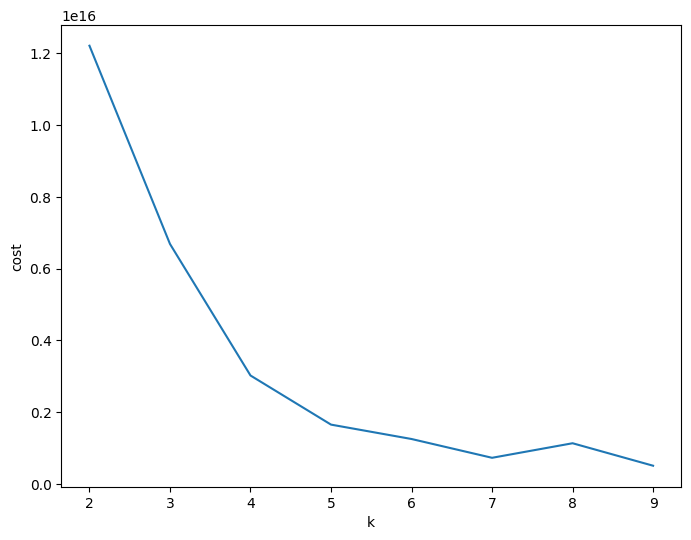

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(range(2, kmax), cost[2:kmax])
ax.set_xlabel("k")
ax.set_ylabel("cost")

4


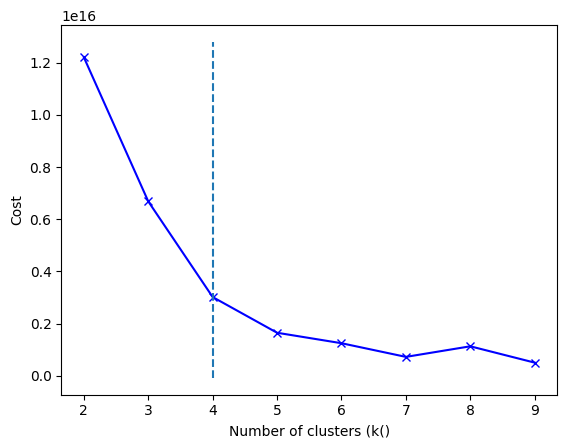

In [22]:
x, y = range(2, kmax), cost[2:kmax]
kn = KneeLocator(x, y, curve="convex", direction="decreasing")
print(kn.knee)

plt.xlabel("Number of clusters (k()")
plt.ylabel("Cost")
plt.plot(x, y, "bx-")
plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles="dashed")

Looks like there was not much gain after 4. Let's go ahead with that and make our predictions. 

In [26]:
k = 4
kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
model = kmeans.fit(final_df)

# Make predictions
predictions = model.transform(final_df)

# Evaluate cluster by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.973382446581744


## Describe the clusters in lamens terms

What are some defining characteristics of each cluster? Try to use some of the variables to explain to the client. 

In [27]:
# First get the centers of each cluster
centers = model.clusterCenters()
center_pdf = pd.DataFrame(list(map(np.ravel, centers)))
center_pdf.columns = input_columns
center_pdf

,UNITID,OPEID,opeid6,HCM2,main,NUMBRANCH,PREDDEG,HIGHDEG,CONTROL,st_fips,...,RET_PT4,RET_PTL4,C200_4_POOLED,C200_L4_POOLED,poolyrs200,D200_4_POOLED,D200_L4_POOLED,PCTFLOAN,UG25abv,CDR3
0,2.816798e+05,1.711735e+06,16229.705312,0.008876,0.778643,6.934043,1.883108,2.288543,2.194319,29.182439,...,0.4493,0.558225,0.491768,0.593543,2.140107,1230.340571,687.13997,0.530181,0.417572,0.125960
1,1.615950e+07,1.145834e+06,11458.251908,0.000000,0.019084,11.835878,0.000000,0.000000,2.301527,23.038168,...,0.4493,0.558225,0.489528,0.593543,2.000000,1224.000000,687.00000,0.531202,0.421227,0.157115
2,4.393810e+07,2.263500e+06,16974.383648,0.025157,0.012579,43.440252,0.000000,0.000000,2.798742,27.962264,...,0.4493,0.558225,0.489528,0.593543,2.000000,1224.000000,687.00000,0.531202,0.421227,0.157415
3,4.414783e+05,4.443218e+07,20988.000000,0.000000,0.000000,71.000000,2.850000,3.750000,3.000000,30.516667,...,0.4493,0.558225,0.216137,0.593543,2.066667,462.816667,687.00000,0.655852,0.867258,0.190000


In [28]:
# Now let's print some take aways for our client
print("Centroid for number of branches in each cluster:")
print(center_pdf.NUMBRANCH)
print("")
print("Centroid for Highest Degree Awarded:")
print("Pretty big disparity between clusters 0 and 1 compared to 2 and 3")
print(center_pdf.HIGHDEG)
print("")
print("Centroid for Locale (higher numbers mean more remote locale):")
print("Looks like there is not a ton of diffence in the clusters here")
print(center_pdf.LOCALE)
print("")
print("Centroid for Historically Black (binary outcome):")
print(
    "Looks like cluter one has a slightly higher rate of historically black universities"
)
print(center_pdf.HBCU)

Centroid for number of branches in each cluster:
0     6.934043
1    11.835878
2    43.440252
3    71.000000
Name: NUMBRANCH, dtype: float64

Centroid for Highest Degree Awarded:
Pretty big disparity between clusters 0 and 1 compared to 2 and 3
0    2.288543
1    0.000000
2    0.000000
3    3.750000
Name: HIGHDEG, dtype: float64

Centroid for Locale (higher numbers mean more remote locale):
Looks like there is not a ton of diffence in the clusters here
0    19.625017
1    19.000000
2    19.000000
3    15.166667
Name: LOCALE, dtype: float64

Centroid for Historically Black (binary outcome):
Looks like cluter one has a slightly higher rate of historically black universities
0    0.013519
1    0.000000
2    0.000000
3    0.000000
Name: HBCU, dtype: float64


## How many Universities are in each cluster?

### First Assign clusters to each row in the original dataframe

In [29]:
transformed = model.transform(final_df).select("UNITID", "prediction")
rows = transformed.collect()
print(rows[:3])

[Row(UNITID=100654, prediction=0), Row(UNITID=100663, prediction=0), Row(UNITID=100690, prediction=0)]


In [30]:
df_pred = spark.createDataFrame(rows)
df_pred.show(5)

+------+----------+
|UNITID|prediction|
+------+----------+
|100654|         0|
|100663|         0|
|100690|         0|
|100706|         0|
|100724|         0|
+------+----------+
only showing top 5 rows



### Join the predictions to the original dataframe so we have all the columns back in their original form

In [31]:
results = df_pred.join(df, "UNITID")
results.limit(5).toPandas()

,UNITID,prediction,OPEID,opeid6,INSTNM,CITY,STABBR,ZIP,AccredAgency,INSTURL,...,COMPL_RPY_3YR_RT_SUPP,NONCOM_RPY_3YR_RT_SUPP,DEP_RPY_3YR_RT_SUPP,IND_RPY_3YR_RT_SUPP,PELL_RPY_3YR_RT_SUPP,NOPELL_RPY_3YR_RT_SUPP,FEMALE_RPY_3YR_RT_SUPP,MALE_RPY_3YR_RT_SUPP,FIRSTGEN_RPY_3YR_RT_SUPP,NOTFIRSTGEN_RPY_3YR_RT_SUPP
0,107123,0,2330800,23308,Jefferson Regional Medical Center School of Nu...,Pine Bluff,AR,71603,Accrediting Bureau of Health Education Schools,www.jrmc.org,...,0.847826087,PrivacySuppressed,PrivacySuppressed,0.764705882,0.744680851,PrivacySuppressed,0.784313725,PrivacySuppressed,0.783783784,PrivacySuppressed
1,133492,0,148700,1487,Eckerd College,Saint Petersburg,FL,33711-4700,Southern Association of Colleges and Schools C...,www.eckerd.edu,...,0.870253165,0.78581363,0.879941435,0.679083095,0.727688787,0.87394958,0.80704441,0.823529412,0.777358491,0.835243553
2,115861,0,121400,1214,Imperial Valley College,Imperial,CA,92251-0158,Western Association of Schools and Colleges Ac...,www.imperial.edu,...,None,None,None,None,None,None,None,None,None,None
3,120272,0,1298900,12989,Oceanside College of Beauty,Oceanside,CA,92054-5356,National Accrediting Commission of Career Arts...,ocb.edu/,...,0.617647059,PrivacySuppressed,PrivacySuppressed,0.6,0.540540541,PrivacySuppressed,0.615384615,PrivacySuppressed,PrivacySuppressed,PrivacySuppressed
4,130174,0,1077900,10779,Porter and Chester Institute of Stratford,Stratford,CT,06615-7158,Accrediting Commission of Career Schools and C...,www.porterchester.com,...,0.5800988,0.307617188,0.599361022,0.445319335,0.409596929,0.712910986,0.491672701,0.518307567,0.503213368,0.567164179


In [32]:
results.groupBy("prediction").count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         0| 7323|
|         3|   60|
|         1|  262|
|         2|  159|
+----------+-----+



## List the Universities by Cluster

In [33]:
uni_list = results.select("INSTNM").filter("prediction == 0")
uni_list.show(truncate=False)

+-----------------------------------------------+
|INSTNM                                         |
+-----------------------------------------------+
|Alabama A & M University                       |
|University of Alabama at Birmingham            |
|Amridge University                             |
|University of Alabama in Huntsville            |
|Alabama State University                       |
|The University of Alabama                      |
|Central Alabama Community College              |
|Athens State University                        |
|Auburn University at Montgomery                |
|Auburn University                              |
|Birmingham Southern College                    |
|Chattahoochee Valley Community College         |
|Concordia College Alabama                      |
|South University-Montgomery                    |
|Enterprise State Community College             |
|James H Faulkner State Community College       |
|Faulkner University                            |


In [34]:
uni_list = results.select("INSTNM").filter("prediction == 1")
uni_list.show(truncate=False)

+-----------------------------------------------------------+
|INSTNM                                                     |
+-----------------------------------------------------------+
|Troy University-Phenix City Campus                         |
|Troy University-Montgomery Campus                          |
|Troy University-Dothan Campus                              |
|Troy University-eTROY                                      |
|Troy University-Global Campus                              |
|Global MBA Latin American Managers Program Satellite Campus|
|Arkansas College of Barbering and Hair Design              |
|Harding School of Theology                                 |
|Career Academy of Hair Design-Siloam Springs               |
|Career Academy of Hair Design-Rogers                       |
|Career Academy of Hair Design-Fayetteville                 |
|Alliant International University-Fresno                    |
|Alliant International University-Los Angeles               |
|Alliant

In [35]:
uni_list = results.select("INSTNM").filter("prediction == 2")
uni_list.show(truncate=False)

+--------------------------------------------------------+
|INSTNM                                                  |
+--------------------------------------------------------+
|Vista College                                           |
|Vista College                                           |
|Computer Career Center-Las Cruces                       |
|Vista College-Beaumont                                  |
|Vista College-Longview                                  |
|Vista College-Killeen                                   |
|Fremont College                                         |
|Rob Roy Academy - Woonsocket                            |
|CC's Cosmetology College                                |
|CC's Cosmetology College                                |
|CC's Cosmetology College-Texarkana                      |
|CC's Cosmetology College-Texarkana                      |
|YTI Career Institute - Altoona                          |
|SW School of Business & Technical Careers              